In [1]:
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
import datetime as dt
from zigzag_dag26 import zigzag
import talib
from tqdm import tqdm
import colorama as col
from retracement import ret_hilo
from bt import *
from fibostoch import Fibo_Stoch
from sklearn.preprocessing import MinMaxScaler

Importing Librairies...


In [2]:
%%time
##### Chargement de la base
base = pd.read_csv('Base_Clean/EURUSDm5.csv')

##### On fixe la date en index sous forme de Timestamp
base.set_index(pd.to_datetime(base.Date),drop=True,inplace=True)

###### On drop les colonnes inutiles
base = base.drop(['Date','Total'],axis=1)

##### On enlève les jours correspondant au samedi et au dimanche
base['WE'] = np.where(((base.index.weekday == 5) | (base.index.weekday == 6)),None,base.index.weekday)
base = base.dropna()
base = base.drop(['WE'],axis=1)


CPU times: user 1.96 s, sys: 270 ms, total: 2.23 s
Wall time: 2.24 s


In [3]:
base.index[0],base.index[-1]

(Timestamp('2010-11-23 00:00:00'), Timestamp('2020-11-23 15:40:00'))

In [4]:
%%time
_year_bottom = pd.to_datetime('2018-01-01 16:00:00')
_year_top = pd.to_datetime('2018-12-31 16:00:00') #2020-11-23 16:00:00

df = base[(base.index>=_year_bottom)&(base.index<=_year_top)]

CPU times: user 7.53 ms, sys: 2.67 ms, total: 10.2 ms
Wall time: 8.69 ms


In [5]:
df['RSI2'] = talib.RSI(df.Close,timeperiod=2)
df['MMA200'] = talib.EMA(df.Close,timeperiod=80)
upper, middle, lower = talib.BBANDS(df.Close, timeperiod=10, nbdevup=2, nbdevdn=2)
#df['SBVol'] = upper - lower

In [6]:
%%time
df['Signal'] = np.where(\
    ((df.RSI2 < 10)&(df.Close>df.MMA200)),1,\
        np.where(\
            ((df.RSI2 > 90)&(df.Close<df.MMA200)),-1,0)
)

CPU times: user 9.22 ms, sys: 3.22 ms, total: 12.4 ms
Wall time: 6.8 ms


In [7]:
_nb_bougie_exit = 3000000000
_trigger_reengage = 0
_trigger_target = 1
_trigger_invers = 0
_trigger_sl = 1
_verbose = 0
_cash_ini = 200000
_rate = 1
x = 'EUR/USD'
_target = 0.002
_exposure = 2
_size = 50000
_sl = 0.004
TRACKER = bt(df,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
        _rate,x,_target,_exposure,_size,_sl)

Librairies imported

Début des opérations horodatée à 2020-12-14 14:57:51.092396

Chargement de la nouvelle base


 Le rate du ticker EUR/USD est à  1 
Bases chargées
TETEL process effectué
 ENTERING THE BACKTEST 
100%|██████████| 73523/73523 [00:07<00:00, 9602.64it/s]
 Pour le ticker  EUR/USD 
 
Les gains faramineux s'élèvent à : $  -2886.5 !. En  444   transactions.
 
Nbre de winners : 282 
 
Nbre de loosers : 162 
Temps d'excution du BT 0:00:13.945350
 EUR/USD  results 
 Tested Period 2018-01-01 16:00:00  à 2018-12-31 16:00:00 
 Total Number of trades 444 
Started Cash : 50000
P&L in currency:  -2886.5$ 
P&L in %:  -1.44% 
Average trade duration 147.81
# Winners  282.0
# Loosers  162.0
Cumulated gains 38247.5
Cumulated losses -41134.0
 PROFIT FACTOR :  0.93 
 Winners Ratio : 63.51 % 
Average Winners 135.63
% Average Winners 0.07
Average Loosers -253.91
% Average Loosers -0.13
Average pnl -6.5
% Average pnl -0.01
Number of opened trades 444
Number of closed trades 444
Max Exposure 1 

In [8]:
len(TRACKER)

282

In [17]:
%%time
scaler = MinMaxScaler((0,1))
df_2 = df.copy()
#df_2.loc[:, df_2.columns != 'Signal'] = scaler.fit_transform(df_2.loc[:, df_2.columns != 'Signal'].values) 
df_2.rename(columns = {'Signal':'Sig4bt'}, inplace = True)
SIGNAL = []
SIGNAL = [1 if (df_2.Sig4bt[i] == 1 or df_2.Sig4bt[i] == -1) & (df_2.index[i] in TRACKER) else 0 for i in tqdm(range(len(df_2)))]
df_2['Signal'] = SIGNAL
df_2 = df_2[['Open','High','Low','Close','RSI2','MMA200','Sig4bt','Signal']]
df_2 = df_2.dropna()
df_2 = df_2.sort_index(axis=1)

100%|██████████| 73602/73602 [00:04<00:00, 18163.53it/s]CPU times: user 4.03 s, sys: 33.9 ms, total: 4.06 s
Wall time: 4.09 s



In [18]:
%%time
# check pycaret version
import pycaret
from pycaret.classification import setup
from pycaret.classification import compare_models

print('PyCaret: %s' % pycaret.__version__)

# setup the dataset
grid = setup(data=df_2.sort_index(axis=1), target='Signal', html=False, silent=False, verbose=True)

# evaluate models and compare models
best = compare_models()

# report the best model
print(best)

PyCaret: 2.2.0


Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
Close,Numeric
High,Numeric
Low,Numeric
MMA200,Numeric
Open,Numeric
RSI2,Numeric
Sig4bt,Categorical
Signal,Label


Setup Succesfully Completed!


,Description,Value
0,session_id,1650
1,Target,Signal
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(73523, 8)"
5,Missing Values,False
6,Numeric Features,6
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.996,0.9719,0.0,0.0,0.0,0.0,0.0,0.586


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9960,0.9719,0.0,0.0,0.0,0.0000,0.0000,0.586
knn,K Neighbors Classifier,0.9958,0.6476,0.0,0.0,0.0,-0.0003,-0.0006,0.139


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9960,0.9719,0.0,0.0000,0.0000,0.0000,0.0000,0.586
knn,K Neighbors Classifier,0.9958,0.6476,0.0,0.0000,0.0000,-0.0003,-0.0006,0.139
nb,Naive Bayes,0.9403,0.9672,1.0,0.0631,0.1188,0.1121,0.2435,0.019


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9960,0.9719,0.0000,0.0000,0.0000,0.0000,0.0000,0.586
knn,K Neighbors Classifier,0.9958,0.6476,0.0000,0.0000,0.0000,-0.0003,-0.0006,0.139
dt,Decision Tree Classifier,0.9929,0.5349,0.0731,0.0871,0.0790,0.0755,0.0760,0.027
nb,Naive Bayes,0.9403,0.9672,1.0000,0.0631,0.1188,0.1121,0.2435,0.019


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9960,0.9719,0.0000,0.0000,0.0000,0.0000,0.0000,0.586
knn,K Neighbors Classifier,0.9958,0.6476,0.0000,0.0000,0.0000,-0.0003,-0.0006,0.139
dt,Decision Tree Classifier,0.9929,0.5349,0.0731,0.0871,0.0790,0.0755,0.0760,0.027
nb,Naive Bayes,0.9403,0.9672,1.0000,0.0631,0.1188,0.1121,0.2435,0.019
svm,SVM - Linear Kernel,0.8896,0.0000,0.2667,0.0094,0.0172,0.0149,0.0344,0.065


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9960,0.9719,0.0000,0.0000,0.0000,0.0000,0.0000,0.586
ridge,Ridge Classifier,0.9960,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.030
knn,K Neighbors Classifier,0.9958,0.6476,0.0000,0.0000,0.0000,-0.0003,-0.0006,0.139
dt,Decision Tree Classifier,0.9929,0.5349,0.0731,0.0871,0.0790,0.0755,0.0760,0.027
nb,Naive Bayes,0.9403,0.9672,1.0000,0.0631,0.1188,0.1121,0.2435,0.019
svm,SVM - Linear Kernel,0.8896,0.0000,0.2667,0.0094,0.0172,0.0149,0.0344,0.065


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9960,0.9719,0.0000,0.0000,0.0000,0.0000,0.0000,0.586
ridge,Ridge Classifier,0.9960,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.030
knn,K Neighbors Classifier,0.9958,0.6476,0.0000,0.0000,0.0000,-0.0003,-0.0006,0.139
dt,Decision Tree Classifier,0.9929,0.5349,0.0731,0.0871,0.0790,0.0755,0.0760,0.027
rf,Random Forest Classifier,0.9929,0.6568,0.0731,0.0871,0.0790,0.0755,0.0760,0.423
nb,Naive Bayes,0.9403,0.9672,1.0000,0.0631,0.1188,0.1121,0.2435,0.019
svm,SVM - Linear Kernel,0.8896,0.0000,0.2667,0.0094,0.0172,0.0149,0.0344,0.065


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9960,0.9719,0.0000,0.0000,0.0000,0.0000,0.0000,0.586
ridge,Ridge Classifier,0.9960,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.030
knn,K Neighbors Classifier,0.9958,0.6476,0.0000,0.0000,0.0000,-0.0003,-0.0006,0.139
dt,Decision Tree Classifier,0.9929,0.5349,0.0731,0.0871,0.0790,0.0755,0.0760,0.027
rf,Random Forest Classifier,0.9929,0.6568,0.0731,0.0871,0.0790,0.0755,0.0760,0.423
nb,Naive Bayes,0.9403,0.9672,1.0000,0.0631,0.1188,0.1121,0.2435,0.019
svm,SVM - Linear Kernel,0.8896,0.0000,0.2667,0.0094,0.0172,0.0149,0.0344,0.065
qda,Quadratic Discriminant Analysis,0.0040,0.0000,1.0000,0.0040,0.0080,0.0000,0.0000,0.027


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9960,0.9719,0.0000,0.0000,0.0000,0.0000,0.0000,0.586
ridge,Ridge Classifier,0.9960,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.030
ada,Ada Boost Classifier,0.9960,0.9779,0.0000,0.0000,0.0000,-0.0000,-0.0001,0.317
knn,K Neighbors Classifier,0.9958,0.6476,0.0000,0.0000,0.0000,-0.0003,-0.0006,0.139
dt,Decision Tree Classifier,0.9929,0.5349,0.0731,0.0871,0.0790,0.0755,0.0760,0.027
rf,Random Forest Classifier,0.9929,0.6568,0.0731,0.0871,0.0790,0.0755,0.0760,0.423
nb,Naive Bayes,0.9403,0.9672,1.0000,0.0631,0.1188,0.1121,0.2435,0.019
svm,SVM - Linear Kernel,0.8896,0.0000,0.2667,0.0094,0.0172,0.0149,0.0344,0.065
qda,Quadratic Discriminant Analysis,0.0040,0.0000,1.0000,0.0040,0.0080,0.0000,0.0000,0.027


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9960,0.9719,0.0000,0.0000,0.0000,0.0000,0.0000,0.586
ridge,Ridge Classifier,0.9960,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.030
ada,Ada Boost Classifier,0.9960,0.9779,0.0000,0.0000,0.0000,-0.0000,-0.0001,0.317
gbc,Gradient Boosting Classifier,0.9959,0.9769,0.0098,0.0833,0.0174,0.0171,0.0278,0.899
knn,K Neighbors Classifier,0.9958,0.6476,0.0000,0.0000,0.0000,-0.0003,-0.0006,0.139
dt,Decision Tree Classifier,0.9929,0.5349,0.0731,0.0871,0.0790,0.0755,0.0760,0.027
rf,Random Forest Classifier,0.9929,0.6568,0.0731,0.0871,0.0790,0.0755,0.0760,0.423
nb,Naive Bayes,0.9403,0.9672,1.0000,0.0631,0.1188,0.1121,0.2435,0.019
svm,SVM - Linear Kernel,0.8896,0.0000,0.2667,0.0094,0.0172,0.0149,0.0344,0.065
qda,Quadratic Discriminant Analysis,0.0040,0.0000,1.0000,0.0040,0.0080,0.0000,0.0000,0.027


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9960,0.9719,0.0000,0.0000,0.0000,0.0000,0.0000,0.586
ridge,Ridge Classifier,0.9960,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.030
ada,Ada Boost Classifier,0.9960,0.9779,0.0000,0.0000,0.0000,-0.0000,-0.0001,0.317
gbc,Gradient Boosting Classifier,0.9959,0.9769,0.0098,0.0833,0.0174,0.0171,0.0278,0.899
knn,K Neighbors Classifier,0.9958,0.6476,0.0000,0.0000,0.0000,-0.0003,-0.0006,0.139
dt,Decision Tree Classifier,0.9929,0.5349,0.0731,0.0871,0.0790,0.0755,0.0760,0.027
rf,Random Forest Classifier,0.9929,0.6568,0.0731,0.0871,0.0790,0.0755,0.0760,0.423
nb,Naive Bayes,0.9403,0.9672,1.0000,0.0631,0.1188,0.1121,0.2435,0.019
lda,Linear Discriminant Analysis,0.9403,0.9709,1.0000,0.0631,0.1188,0.1121,0.2435,0.042
svm,SVM - Linear Kernel,0.8896,0.0000,0.2667,0.0094,0.0172,0.0149,0.0344,0.065


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9960,0.9719,0.0000,0.0000,0.0000,0.0000,0.0000,0.586
ridge,Ridge Classifier,0.9960,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.030
ada,Ada Boost Classifier,0.9960,0.9779,0.0000,0.0000,0.0000,-0.0000,-0.0001,0.317
gbc,Gradient Boosting Classifier,0.9959,0.9769,0.0098,0.0833,0.0174,0.0171,0.0278,0.899
knn,K Neighbors Classifier,0.9958,0.6476,0.0000,0.0000,0.0000,-0.0003,-0.0006,0.139
et,Extra Trees Classifier,0.9930,0.5673,0.0729,0.0856,0.0785,0.0750,0.0754,0.313
dt,Decision Tree Classifier,0.9929,0.5349,0.0731,0.0871,0.0790,0.0755,0.0760,0.027
rf,Random Forest Classifier,0.9929,0.6568,0.0731,0.0871,0.0790,0.0755,0.0760,0.423
nb,Naive Bayes,0.9403,0.9672,1.0000,0.0631,0.1188,0.1121,0.2435,0.019
lda,Linear Discriminant Analysis,0.9403,0.9709,1.0000,0.0631,0.1188,0.1121,0.2435,0.042


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9960,0.9719,0.0000,0.0000,0.0000,0.0000,0.0000,0.586
ridge,Ridge Classifier,0.9960,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.030
ada,Ada Boost Classifier,0.9960,0.9779,0.0000,0.0000,0.0000,-0.0000,-0.0001,0.317
gbc,Gradient Boosting Classifier,0.9959,0.9769,0.0098,0.0833,0.0174,0.0171,0.0278,0.899
knn,K Neighbors Classifier,0.9958,0.6476,0.0000,0.0000,0.0000,-0.0003,-0.0006,0.139
et,Extra Trees Classifier,0.9930,0.5673,0.0729,0.0856,0.0785,0.0750,0.0754,0.313
dt,Decision Tree Classifier,0.9929,0.5349,0.0731,0.0871,0.0790,0.0755,0.0760,0.027
rf,Random Forest Classifier,0.9929,0.6568,0.0731,0.0871,0.0790,0.0755,0.0760,0.423
nb,Naive Bayes,0.9403,0.9672,1.0000,0.0631,0.1188,0.1121,0.2435,0.019
lda,Linear Discriminant Analysis,0.9403,0.9709,1.0000,0.0631,0.1188,0.1121,0.2435,0.042


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9960,0.9719,0.0000,0.0000,0.0000,0.0000,0.0000,0.586
ridge,Ridge Classifier,0.9960,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.030
ada,Ada Boost Classifier,0.9960,0.9779,0.0000,0.0000,0.0000,-0.0000,-0.0001,0.317
lightgbm,Light Gradient Boosting Machine,0.9960,0.9761,0.0000,0.0000,0.0000,0.0000,0.0000,0.133
gbc,Gradient Boosting Classifier,0.9959,0.9769,0.0098,0.0833,0.0174,0.0171,0.0278,0.899
knn,K Neighbors Classifier,0.9958,0.6476,0.0000,0.0000,0.0000,-0.0003,-0.0006,0.139
et,Extra Trees Classifier,0.9930,0.5673,0.0729,0.0856,0.0785,0.0750,0.0754,0.313
dt,Decision Tree Classifier,0.9929,0.5349,0.0731,0.0871,0.0790,0.0755,0.0760,0.027
rf,Random Forest Classifier,0.9929,0.6568,0.0731,0.0871,0.0790,0.0755,0.0760,0.423
nb,Naive Bayes,0.9403,0.9672,1.0000,0.0631,0.1188,0.1121,0.2435,0.019


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9960,0.9719,0.0000,0.0000,0.0000,0.0000,0.0000,0.586
ridge,Ridge Classifier,0.9960,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.030
ada,Ada Boost Classifier,0.9960,0.9779,0.0000,0.0000,0.0000,-0.0000,-0.0001,0.317
lightgbm,Light Gradient Boosting Machine,0.9960,0.9761,0.0000,0.0000,0.0000,0.0000,0.0000,0.133
catboost,CatBoost Classifier,0.9960,0.9761,0.0000,0.0000,0.0000,0.0000,0.0000,17.111
gbc,Gradient Boosting Classifier,0.9959,0.9769,0.0098,0.0833,0.0174,0.0171,0.0278,0.899
knn,K Neighbors Classifier,0.9958,0.6476,0.0000,0.0000,0.0000,-0.0003,-0.0006,0.139
et,Extra Trees Classifier,0.9930,0.5673,0.0729,0.0856,0.0785,0.0750,0.0754,0.313
dt,Decision Tree Classifier,0.9929,0.5349,0.0731,0.0871,0.0790,0.0755,0.0760,0.027
rf,Random Forest Classifier,0.9929,0.6568,0.0731,0.0871,0.0790,0.0755,0.0760,0.423


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9960,0.9719,0.0000,0.0000,0.0000,0.0000,0.0000,0.586
ridge,Ridge Classifier,0.9960,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.030
ada,Ada Boost Classifier,0.9960,0.9779,0.0000,0.0000,0.0000,-0.0000,-0.0001,0.317
lightgbm,Light Gradient Boosting Machine,0.9960,0.9761,0.0000,0.0000,0.0000,0.0000,0.0000,0.133
catboost,CatBoost Classifier,0.9960,0.9761,0.0000,0.0000,0.0000,0.0000,0.0000,17.111
gbc,Gradient Boosting Classifier,0.9959,0.9769,0.0098,0.0833,0.0174,0.0171,0.0278,0.899
knn,K Neighbors Classifier,0.9958,0.6476,0.0000,0.0000,0.0000,-0.0003,-0.0006,0.139
et,Extra Trees Classifier,0.9930,0.5673,0.0729,0.0856,0.0785,0.0750,0.0754,0.313
dt,Decision Tree Classifier,0.9929,0.5349,0.0731,0.0871,0.0790,0.0755,0.0760,0.027
rf,Random Forest Classifier,0.9929,0.6568,0.0731,0.0871,0.0790,0.0755,0.0760,0.423


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1650, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
CPU times: user 7.87 s, sys: 1.03 s, total: 8.89 s
Wall time: 3min 31s


In [22]:
%%time
from reglog import modelize
_model = 'reglog'
modelize(df_2[df_2.Sig4bt != 0],x,_model,0)

 Regression Logistique pour  EUR/USD 
Signaux achat Counter({0: 4417, 1: 282})
 Pour  EUR/USD 

Achat - Accuracy : 94.01 %
Achat - Precision : 0.0 %
Achat - Recall : 0.0 %
Achat - F-measure: : 0.0 % 


              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3093
           1       0.00      0.00      0.00       197

    accuracy                           0.94      3290
   macro avg       0.47      0.50      0.48      3290
weighted avg       0.88      0.94      0.91      3290

              Vrais_estimés    Faux_estimés
vrais_réels  Vrais_positifs    Faux_négatif
Faux_réels    Faux_positifs  Vrais-négatifs
[[3093    0]
 [ 197    0]]


 Joblib Model  JOBLIB/reglog/SaveEURUSDm5.sav  dumped to disk 
Best Threshold=0.000000, F-Score=0.113
CPU times: user 171 ms, sys: 32.2 ms, total: 203 ms
Wall time: 63 ms


()

In [23]:
%%time
print('Modèle retenu, ',_model)
_year_bottom = pd.to_datetime('2020-01-01 16:00:00')
_year_top = pd.to_datetime('2020-11-23 16:00:00') #2020-11-23 16:00:00

df_oos = base[(base.index>=_year_bottom)&(base.index<=_year_top)]

df_oos['RSI2'] = talib.RSI(df_oos.Close,timeperiod=2)
df_oos['MMA200'] = talib.EMA(df_oos.Close,timeperiod=80)
upper, middle, lower = talib.BBANDS(df_oos.Close, timeperiod=10, nbdevup=2, nbdevdn=2)

df_oos['Signal'] = np.where(\
    ((df_oos.RSI2 < 10)&(df_oos.Close>df_oos.MMA200)),1,\
        np.where(\
            ((df_oos.RSI2 > 90)&(df_oos.Close<df_oos.MMA200)),-1,0)
)

#df_oos.loc[:, df_oos.columns != 'Signal'] = scaler.fit_transform(df_oos.loc[:, df_oos.columns != 'Signal'].values) 
df_oos.rename(columns = {'Signal':'Sig4bt'}, inplace = True)


loaded_model = joblib.load('JOBLIB/'+_model+'/SaveEURUSDm5.sav')
df_oos = df_oos.dropna()
df_oos = df_oos.sort_index(axis=1)

df_oos['Signal_hat'] = loaded_model.predict(scaler.fit_transform(df_oos[['Open','High','Low','Close','RSI2','MMA200','Sig4bt']].values))

df_oos['Signal'] = np.where(
                            ((df_oos.Sig4bt == 1)&(df_oos.Signal_hat==0)),1,\
                                np.where(((df_oos.Sig4bt == -1)&(df_oos.Signal_hat==0)),-1,0)


)



Modèle retenu,  reglog
CPU times: user 58.2 ms, sys: 18.8 ms, total: 77 ms
Wall time: 56.2 ms


In [24]:
_nb_bougie_exit = 70000000000
_trigger_reengage = 0
_trigger_target = 1
_trigger_invers = 0
_trigger_sl = 1
_verbose = 0
_cash_ini = 200000
_rate = 1
x = 'EUR/USD'
_target = 0.002
_exposure = 3
_size = 50000
_sl = 0.002

bt(df_oos,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
        _rate,x,_target,_exposure,_size,_sl)

Librairies imported

Début des opérations horodatée à 2020-12-14 16:06:26.248958

Chargement de la nouvelle base


 Le rate du ticker EUR/USD est à  1 
Bases chargées
TETEL process effectué
 ENTERING THE BACKTEST 
100%|██████████| 65978/65978 [00:06<00:00, 9511.45it/s]
 Pour le ticker  EUR/USD 
 
Les gains faramineux s'élèvent à : $  -709.5 !. En  653   transactions.
 
Nbre de winners : 325 
 
Nbre de loosers : 328 
Temps d'excution du BT 0:00:13.201516
 EUR/USD  results 
 Tested Period 2020-01-01 16:00:00  à 2020-11-23 16:00:00 
 Total Number of trades 653 
Started Cash : 50000
P&L in currency:  -709.5$ 
P&L in %:  -0.35% 
Average trade duration 79.31
# Winners  325.0
# Loosers  328.0
Cumulated gains 41989.0
Cumulated losses -42698.5
 PROFIT FACTOR :  0.98 
 Winners Ratio : 49.77 % 
Average Winners 129.2
% Average Winners 0.06
Average Loosers -130.18
% Average Loosers -0.07
Average pnl -1.09
% Average pnl -0.0
Number of opened trades 653
Number of closed trades 653
Max Exposure 1 x  5

[Timestamp('2020-01-02 15:55:00'),
 Timestamp('2020-01-02 19:20:00'),
 Timestamp('2020-01-03 19:20:00'),
 Timestamp('2020-01-07 10:30:00'),
 Timestamp('2020-01-08 11:30:00'),
 Timestamp('2020-01-08 15:35:00'),
 Timestamp('2020-01-10 19:40:00'),
 Timestamp('2020-01-17 14:05:00'),
 Timestamp('2020-01-23 19:05:00'),
 Timestamp('2020-01-27 11:50:00'),
 Timestamp('2020-01-30 18:40:00'),
 Timestamp('2020-01-31 15:35:00'),
 Timestamp('2020-02-03 17:55:00'),
 Timestamp('2020-02-05 13:35:00'),
 Timestamp('2020-02-05 18:55:00'),
 Timestamp('2020-02-06 21:25:00'),
 Timestamp('2020-02-07 13:20:00'),
 Timestamp('2020-02-10 17:10:00'),
 Timestamp('2020-02-11 02:40:00'),
 Timestamp('2020-02-12 22:15:00'),
 Timestamp('2020-02-13 20:40:00'),
 Timestamp('2020-02-21 11:55:00'),
 Timestamp('2020-02-24 01:00:00'),
 Timestamp('2020-02-25 18:50:00'),
 Timestamp('2020-02-26 22:10:00'),
 Timestamp('2020-02-27 08:15:00'),
 Timestamp('2020-02-27 13:00:00'),
 Timestamp('2020-02-27 16:10:00'),
 Timestamp('2020-02-

In [53]:
from svm import modelize
from sklearn.preprocessing import MinMaxScaler

In [54]:
_model = 'svm'
scaler = MinMaxScaler((0,1))
df_2 = df.copy()
#df_2 = df_2.drop(['Peak','Valley','BackHi_pic','BackLo_val'],axis=1)
df_2.loc[:, df_2.columns != 'Signal'] = scaler.fit_transform(df_2.loc[:, df_2.columns != 'Signal'].values) 
df_2.rename(columns = {'Signal':'SigRSI'}, inplace = True)
SIGNAL = []
SIGNAL = [1 if (df_2.SigRSI[i] != 0) & (df_2.index[i] in TRACKER) else 0 for i in tqdm(range(len(df_2)))]
df_2['Signal'] = SIGNAL
df_2 = df_2.dropna()
modelize(df_2[df_2.SigRSI != 0],x,_model,0)

100%|██████████| 503/503 [00:00<00:00, 14986.79it/s] Support Vector Machine pour  EUR/USD 
DF (Les 20% de la fin ont été enlevé pour un OOST ultérieur
Signaux achat Counter({0: 8, 1: 1})
 Not enough populated for  EUR/USD 



()

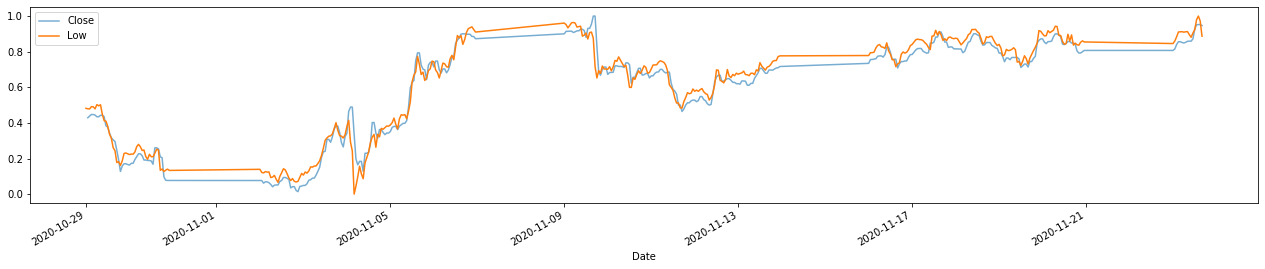

In [58]:
df_2['HiWin'] = df_2.High.rolling(2).max()
df_2.HiWin.plot(figsize=(22,4),label='Close',alpha=0.6)
df_2.Low.plot()
#df_2.HiWin.plot(alpha=0.4)
#df_2.MMA200.plot(alpha=0.6)
#plt.scatter(x=df_2[df_2.Signal==1].index,y=df_2[df_2.Signal==1].Close,color='green',marker='o')
#df_2.High.plot(alpha=0.5)
#df_2.Low.plot()
#plt.scatter(x=df_2[df_2.SigRSI==1].index,y=df_2[df_2.SigRSI==1].Close,color='green',marker='^')

#plt.scatter(x=df_2[df_2.SigRSI==-1].index,y=df_2[df_2.SigRSI==-1].Close,color='red',marker='v')

plt.legend()

In [43]:
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
from numpy import sqrt
from numpy import argmax
import colorama as col
from collections import Counter
import joblib

import pyttsx3
engine = pyttsx3.init()

import configparser
config = configparser.ConfigParser()
print(col.Fore.BLUE,'Support Vector Machine pour',col.Fore.YELLOW,x,col.Style.RESET_ALL)

### Isolation de la partie out of sample ####

#df.iloc[-int(len(df) * 0.2):,:].to_csv(_path5+x.replace('/','')+_period1+'.csv')

#print(df.head())

Xb = df_2.copy()
try:
    Xb = Xb.set_index(Xb.Date, drop =True)
except:
    pass
yb = Xb['Signal']
Xb = Xb.loc[:, Xb.columns != 'Signal']

# summarize class distribution
counterb = Counter(yb)

print('Signaux achat',counterb)
#print(counterb[-1],counterb[1])

if counterb[1] > 2 and counterb[0] > 2:

    # split into train/test sets with same class ratio
    trainXb, testXb, trainyb, testyb = train_test_split(Xb, yb, test_size=0.7, stratify=yb)
    # define model
    model = svm.SVC(kernel='rbf',random_state=770)
    # fit model
    model.fit(trainXb, trainyb)
    # predict on test set
    yhatb = model.predict(testXb)
    # evaluate predictions
    accub = round(accuracy_score(testyb, yhatb) * 100,2)
    precb = round(precision_score(testyb, yhatb) * 100,2)
    recallb = round(recall_score(testyb, yhatb) * 100,2)
    f1b = round(f1_score(testyb, yhatb) * 100,2)

    print(col.Fore.BLUE,'Achat pour',col.Fore.YELLOW,x,col.Style.RESET_ALL)
    if accub > 69 and precb > 69 :
        print(col.Fore.GREEN)
    elif accub < 51 or precb < 51 :
        print(col.Fore.RED)
    else:
        print(col.Fore.YELLOW)

    print('Achat - Accuracy :' ,accub,'%')
    print('Achat - Precision :',precb,'%')
    print('Achat - Recall :', recallb,'%')
    print('Achat - F-measure: :' ,f1b,'%',col.Style.RESET_ALL)
    print('\n')
    
    print(classification_report(testyb, yhatb))
    conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
    conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
    conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
    print(confusion_matrix(testyb, yhatb))
    print('\n')

    savename = 'JOBLIB/'+_model+'/Save'+x.replace('/','')+'m5.sav'
    
    # some time later...
    
    # load the model from disk
    #loaded_model = joblib.load(filename)
    #result = loaded_model.score(X_test, Y_test)
    #print(result)

    # serialize model to JOBLIB
    joblib.dump(model, savename)
    print(col.Fore.BLUE,"Joblib Model ",savename," dumped to disk",col.Style.RESET_ALL)
    
    precisionb, recallb, thresholdsb = precision_recall_curve(testyb, yhatb)
    # plot the roc curve for the model
    no_skillb= len(testyb[testyb==1]) / len(testyb)

    # convert to f score
    fscoreb = (2 * precisionb * recallb) / (precisionb + recallb)
    # locate the index of the largest f score
    ixb = argmax(fscoreb)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholdsb[ixb], fscoreb[ixb]))
    if _verbose == 1:
        plt.ion()
        plt.figure(figsize=(12,4))
        plt.suptitle('Recall_Precision Curve la dataframe')
        plt.plot([0,1], [no_skillb,no_skillb], linestyle='--', label='No Skill')
        plt.plot(recallb, precisionb, marker='.', label='Logistic')
        plt.scatter(recallb[ixb], precisionb[ixb], marker='o', color='black', label='Best')
        # axis labels
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        # show the plot
        plt.show()

else:
    print(col.Fore.RED,'Not enough populated for',col.Fore.YELLOW,x,col.Style.RESET_ALL)

 Support Vector Machine pour  EUR/USD 
Signaux achat Counter({0: 3013, 1: 22})
 Achat pour  EUR/USD 

Achat - Accuracy : 99.34 %
Achat - Precision : 100.0 %
Achat - Recall : 6.67 %
Achat - F-measure: : 12.5 % 


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2110
           1       1.00      0.07      0.12        15

    accuracy                           0.99      2125
   macro avg       1.00      0.53      0.56      2125
weighted avg       0.99      0.99      0.99      2125

[[2110    0]
 [  14    1]]


 Joblib Model  JOBLIB/svm/SaveEURUSDm5.sav  dumped to disk 
Best Threshold=1.000000, F-Score=0.125


In [ ]:
%%time
_year_bottom = pd.to_datetime('2020-05-23 16:00:00')
_year_top = pd.to_datetime('2020-11-23 16:00:00') #2020-11-23 16:00:00

df_bt = base[(base.index>=_year_bottom)&(base.index<=_year_top)]

df['RSI2'] = talib.RSI(df.Close,timeperiod=2)
df['MMA200'] = talib.EMA(df.Close,timeperiod=80)
upper, middle, lower = talib.BBANDS(df.Close, timeperiod=10, nbdevup=2, nbdevdn=2)

df['Signal'] = np.where(\
    ((df.RSI2 < 5)&(df.Close>df.MMA200)),1,\
        np.where(\
            ((df.RSI2 > 95)&(df.Close<df.MMA200)),-1,0)
)

